In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import pandas as pd 
data=pd.read_csv('dataset.csv')
data.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Target
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,0
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,0
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,0
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,0
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset.csv')

target_variable = 'Target'
features = data.drop(columns=[target_variable, 'index'])

train_size = 0.75
stratify_by = data[target_variable]
X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                      data[target_variable],
                                                      train_size=train_size,
                                                      stratify=stratify_by)

input_shape = [X_train.shape[1]]
print("Input shape is ", input_shape)
print(features.head())


Input shape is  [30]
   having_IPhaving_IP_Address  URLURL_Length  Shortining_Service  \
0                          -1              1                   1   
1                           1              1                   1   
2                           1              0                   1   
3                           1              0                   1   
4                           1              0                  -1   

   having_At_Symbol  double_slash_redirecting  Prefix_Suffix  \
0                 1                        -1             -1   
1                 1                         1             -1   
2                 1                         1             -1   
3                 1                         1             -1   
4                 1                         1             -1   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  Favicon  \
0                 -1              -1                           -1        1   
1                  0         

In [5]:
import pandas as pd
import numpy as np
import hashlib
import cv2
import os

def encode_row_as_image(row, image_shape):
    hash_value = hashlib.sha256(row.to_string().encode('utf-8')).hexdigest()
    hash_int = int(hash_value, 16)
    hash_str = str(hash_int).zfill(image_shape[0]*image_shape[1])
    hash_matrix = np.array([int(c) for c in hash_str]).reshape(image_shape)
    hash_image = cv2.resize(hash_matrix, image_shape, interpolation=cv2.INTER_NEAREST)
    return hash_image

def encode_csv_as_images(csv_path, image_dir, image_shape):
    df = pd.read_csv(csv_path)
    target_feature = 'Target' # Change this to the name of your target feature column
    target_values = df[target_feature].unique()
    for value in target_values:
        sub_dir = os.path.join(image_dir, str(value))
        os.makedirs(sub_dir, exist_ok=True)
        for index, row in df[df[target_feature] == value].iterrows():
            image_name = f"{index}.png"
            image_path = os.path.join(sub_dir, image_name)
            hash_image = encode_row_as_image(row, image_shape)
            cv2.imwrite(image_path, hash_image)

csv_path = '/content/dataset.csv'
image_dir = '/content/encodeimg'

encode_csv_as_images(csv_path, image_dir, (10, 10))


In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator


def create_model():
    # Load the VGG16 model without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
    
    # Add a new top layer for our classification task
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:

# Define the data generators for the training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
        image_dir,
        target_size=(500, 500),
        batch_size=32,
        class_mode='binary',
        subset='training')
validation_generator = train_datagen.flow_from_directory(
        image_dir,
        target_size=(500, 500),
        batch_size=32,
        class_mode='binary',
        subset='validation')
model = create_model()
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=25,
    validation_data=validation_generator
)

# Save the trained model
model.save('my_model.h5')

Found 8845 images belonging to 2 classes.
Found 2210 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-7-de8d381e07c0>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
10/10 [==============================] - 75s 5s/step - loss: 8.9276 - accuracy: 0.4812 - val_loss: 0.8843 - val_accuracy: 0.5570
Epoch 2/25
10/10 [==============================] - 89s 10s/step - loss: 0.8159 - accuracy: 0.5406 - val_loss: 0.7639 - val_accuracy: 0.4430
Epoch 3/25
10/10 [==============================] - 54s 6s/step - loss: 0.7235 - accuracy: 0.5094 - val_loss: 0.7231 - val_accuracy: 0.5570
Epoch 4/25
10/10 [==============================] - 54s 6s/step - loss: 0.7227 - accuracy: 0.5250 - val_loss: 0.7020 - val_accuracy: 0.4430
Epoch 5/25
10/10 [==============================] - 52s 6s/step - loss: 0.6984 - accuracy: 0.4719 - val_loss: 0.6944 - val_accuracy: 0.5570
Epoch 6/25
10/10 [==============================] - 53s 6s/step - loss: 0.7008 - accuracy: 0.5250 - val_loss: 0.6874 - val_accuracy: 0.5570
Epoch 7/25
10/10 [==============================] - 54s 6s/step - loss: 0.6935 - accuracy: 0.5063 - val_loss: 0.6947 - val_accuracy: 0.4430
Epoch 8/25
10/10 [=

In [9]:
valid_generator = validation_generator
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = test_datagen.flow_from_directory(
        image_dir,
        target_size=(500, 500),
        batch_size=32,
        class_mode='binary')

valid_loss, valid_acc = model.evaluate_generator(valid_generator)
test_loss, test_acc = model.evaluate_generator(test_generator)

# Generate predictions for the validation and test sets
valid_predictions = model.predict_generator(valid_generator)
test_predictions = model.predict_generator(test_generator)

# Convert the predictions to binary class labels
valid_labels = valid_generator.classes
test_labels = test_generator.classes
valid_predictions = valid_predictions > 0.5
test_predictions = test_predictions > 0.5

# Compute evaluation metrics for the validation and test sets
valid_report = classification_report(valid_labels, valid_predictions)
test_report = classification_report(test_labels, test_predictions)

# Print evaluation metrics
print('Validation F1 score:', valid_report['weighted avg']['f1-score'])
print('Validation recall:', valid_report['weighted avg']['recall'])
print('Validation accuracy:', valid_acc)
print('Validation loss:', valid_loss)

print('Test F1 score:', test_report['weighted avg']['f1-score'])
print('Test recall:', test_report['weighted avg']['recall'])
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Found 11055 images belonging to 2 classes.


<ipython-input-9-4e388115990d>:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_acc = model.evaluate_generator(valid_generator)
<ipython-input-9-4e388115990d>:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator)


KeyboardInterrupt: ignored

In [10]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy',keras.metrics.Precision(),keras.metrics.Recall()],
    
)

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
130/130 [==============================] - 5s 14ms/step - loss: 0.2280 - binary_accuracy: 0.9139 - precision: 0.9212 - recall: 0.9244 - val_loss: 0.2439 - val_binary_accuracy: 0.9291 - val_precision: 0.9097 - val_recall: 0.9688
Epoch 2/50
130/130 [==============================] - 1s 8ms/step - loss: 0.1706 - binary_accuracy: 0.9338 - precision: 0.9367 - recall: 0.9450 - val_loss: 0.1508 - val_binary_accuracy: 0.9392 - val_precision: 0.9266 - val_recall: 0.9675
Epoch 3/50
130/130 [==============================] - 1s 8ms/step - loss: 0.1400 - binary_accuracy: 0.9421 - precision: 0.9412 - recall: 0.9558 - val_loss: 0.1159 - val_binary_accuracy: 0.9512 - val_precision: 0.9488 - val_recall: 0.9643
Epoch 4/50
130/130 [==============================] - 1s 8ms/step - loss: 0.1226 - binary_accuracy: 0.9486 - precision: 0.9473 - recall: 0.9612 - val_loss: 0.1040 - val_binary_accuracy: 0.9551 - val_precision: 0.9603 - val_recall: 0.9591
Epoch 5/50
130/130 [===========================

# Evaluation Metrics

Best Validation Loss: 0.07228182256221771
Best Validation Accuracy: 0.9692474603652954
Best Recall: 0.992852509021759
Best Precision: 0.9706840515136719


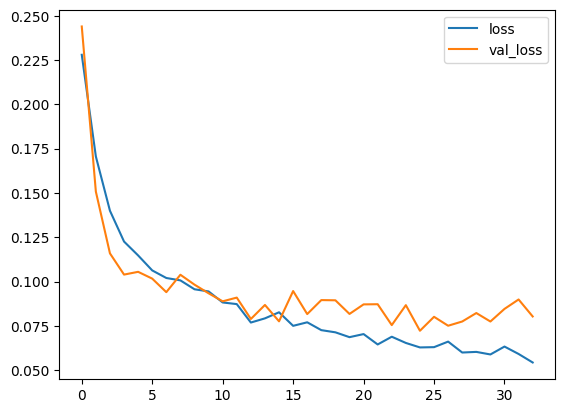

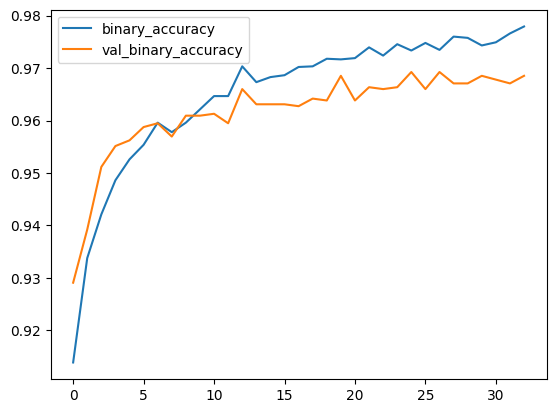

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(f"Best Validation Loss: {history_df['val_loss'].min()}" +\
      f"\nBest Validation Accuracy: {history_df['val_binary_accuracy'].max()}"+\
      f"\nBest Recall: {history_df['val_recall'].max()}" +\
      f"\nBest Precision: {history_df['val_precision'].max()}"
)

In [16]:
history_df = pd.DataFrame(history.history)
print(history_df)
# history_df.loc[0:, ['loss', 'val_loss']].plot()
# history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

print(f"Best Validation Loss: {history_df['loss'].min()}" +\
      f"\nBest Validation Accuracy: {history_df['binary_accuracy'].max()}" +\
      f"Best Validation Loss: {history_df['recall'].min()}" +\
      f"Best Validation Loss: {history_df['precision'].min()}")
# +\
      # f"\nBest Recall: {history_df['val_recall'].max()}" +\
      # f"\nBest Precision: {history_df['val_precision'].max()}"

        loss  binary_accuracy  precision    recall  val_loss  \
0   0.227958         0.913882   0.921234  0.924426  0.243922   
1   0.170587         0.933784   0.936682  0.944998  0.150766   
2   0.139986         0.942106   0.941151  0.955825  0.115934   
3   0.122599         0.948619   0.947290  0.961239  0.103963   
4   0.114766         0.952599   0.954790  0.960372  0.105524   
5   0.106318         0.955373   0.955013  0.965353  0.101686   
6   0.102048         0.959595   0.961232  0.966436  0.094058   
7   0.100689         0.957786   0.959122  0.965353  0.103875   
8   0.095687         0.959595   0.961829  0.965786  0.098293   
9   0.094462         0.962128   0.963194  0.969034  0.093411   
10  0.088244         0.964660   0.965956  0.970767  0.088887   
11  0.087318         0.964660   0.966358  0.970333  0.090986   
12  0.076916         0.970329   0.969905  0.977046  0.078923   
13  0.079277         0.967314   0.968730  0.972715  0.086837   
14  0.082702         0.968279   0.969188